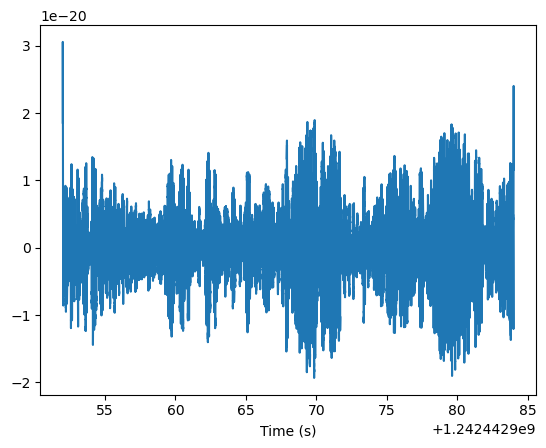

In [1]:
import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
%matplotlib inline

# As an example we use the GW150914 data
merger = Merger("GW190521", source = 'gwtc-2')

# Get the data from the Hanford detector
strain = merger.strain('L1')

# Remove the low frequency content and downsample the data to 2048Hz
strain = highpass(strain, 15.0)
strain = resample_to_delta_t(strain, 1.0/2048)

pylab.plot(strain.sample_times, strain)
pylab.xlabel('Time (s)')
pylab.show()

import pylab
from pycbc.catalog import Merger
from pycbc.filter import resample_to_delta_t, highpass
from pycbc.psd import interpolate, inverse_spectrum_truncation

def whiten_and_peak(event,detector):
    merger = Merger(event)
    strain = merger.strain(detector)
    
    strain = highpass(strain, 15.0)
    strain = resample_to_delta_t(strain, 1.0/2048)
    conditioned = strain.crop(2, 2)
    psd = conditioned.psd(4)
    psd = interpolate(psd, conditioned.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),low_frequency_cutoff=15)
    
    white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
    white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
    white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
    
    n = white_data.abs_arg_max()
    tp = white_data.sample_times[n]
    
    return tp
    

import pycbc
def whiten_peak(array, samp_freq, start_time):
    #start_time is not gps time, it is the time of the first sample
    strain = pycbc.types.timeseries.TimeSeries(array,delta_t = 1/samp_freq, epoch = start_time)
    
    strain = highpass(strain, 15.0)
    strain = resample_to_delta_t(strain, 1.0/2048)
    conditioned = strain.crop(2, 2)
    psd = conditioned.psd(4)
    psd = interpolate(psd, conditioned.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),low_frequency_cutoff=15)
    
    white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
    white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
    #white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
    
    n = white_data.abs_arg_max()
    tp = white_data.sample_times[n]
    
    return tp

import readligo as rl
strain_H1, time_H1, chan_dict_H1 = rl.loaddata('H-H1_LOSC_4_V2-1126257414-4096.hdf5', 'H1')
print(whiten_peak(strain_H1,4096,time_H1[0]))

whiten_and_peak('GW150914','H1')

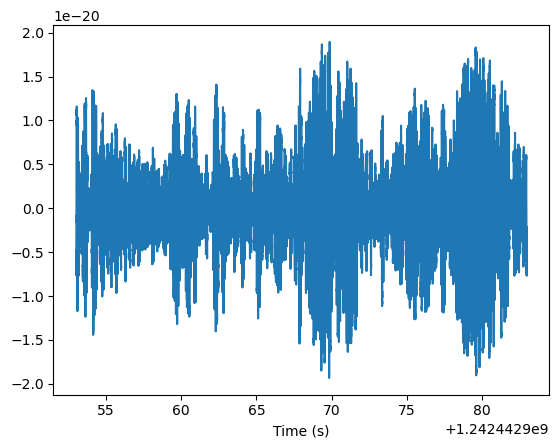

In [2]:
# Remove 2 seconds of data from both the beginning and end
conditioned = strain.crop(1, 1)

pylab.plot(conditioned.sample_times, conditioned)
pylab.xlabel('Time (s)')
pylab.show()

In [3]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
# Estimate the power spectral density

# We use 4 second samples of our time series in Welch method.
psd = conditioned.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd, conditioned.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, int(4 * conditioned.sample_rate),
                                  low_frequency_cutoff=15)

In [4]:
from pycbc.waveform import get_td_waveform

m = 36 # Solar masses
hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                     mass1=90,
                     mass2=40,
                     delta_t=conditioned.delta_t,
                     f_lower=20)

# Resize the vector to match our data
hp.resize(len(conditioned))

Text(0, 0.5, 'Strain')

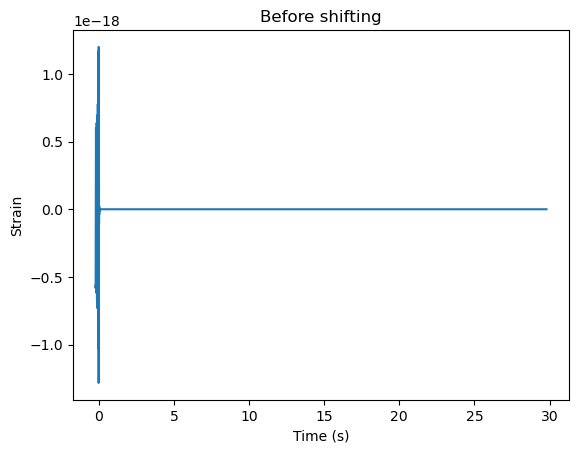

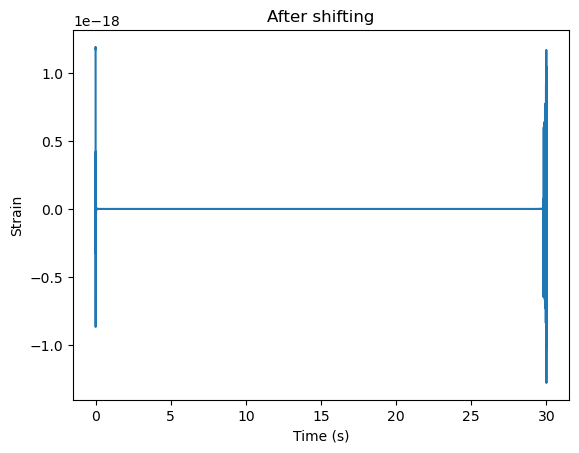

In [5]:
# Let's plot the signal before and after shifting

pylab.figure()
pylab.title('Before shifting')
pylab.plot(hp.sample_times, hp)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

template = hp.cyclic_time_shift(hp.start_time)

pylab.figure()
pylab.title('After shifting')
pylab.plot(template.sample_times, template)
pylab.xlabel('Time (s)')
pylab.ylabel('Strain')

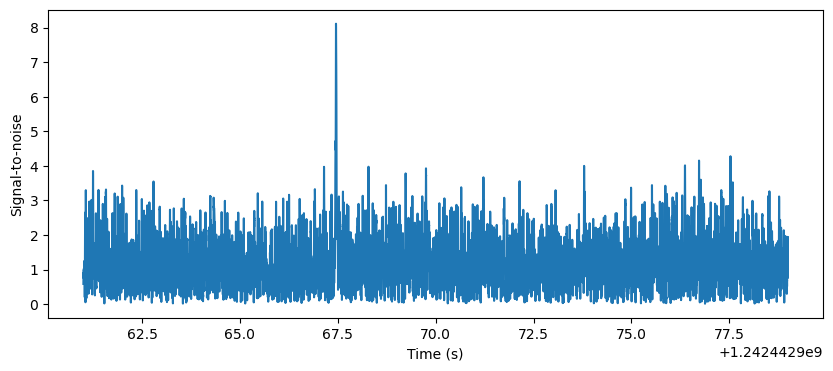

We found a signal at 1242442967.4536133s with SNR 8.113593080199617


In [6]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, conditioned,
                     psd=psd, low_frequency_cutoff=20)

# Remove time corrupted by the template filter and the psd filter
# We remove 4 seconds at the beginning and end for the PSD filtering
# And we remove 4 additional seconds at the beginning to account for
# the template length (this is somewhat generous for 
# so short a template). A longer signal such as from a BNS, would 
# require much more padding at the beginning of the vector.
snr = snr.crop(4 + 4, 4)

# Why are we taking an abs() here?
# The `matched_filter` function actually returns a 'complex' SNR.
# What that means is that the real portion correponds to the SNR
# associated with directly filtering the template with the data.
# The imaginary portion corresponds to filtering with a template that
# is 90 degrees out of phase. Since the phase of a signal may be 
# anything, we choose to maximize over the phase of the signal.
pylab.figure(figsize=[10, 4])
pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()

peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

In [7]:
from pycbc.filter import sigma
# The time, amplitude, and phase of the SNR peak tell us how to align
# our proposed signal with the data.

# Shift the template to the peak time
dt = time - conditioned.start_time
aligned = template.cyclic_time_shift(dt)

# scale the template so that it would have SNR 1 in this data
aligned /= sigma(aligned, psd=psd, low_frequency_cutoff=20.0)

# Scale the template amplitude and phase to the peak value
aligned = (aligned.to_frequencyseries() * snrp).to_timeseries()
aligned.start_time = conditioned.start_time

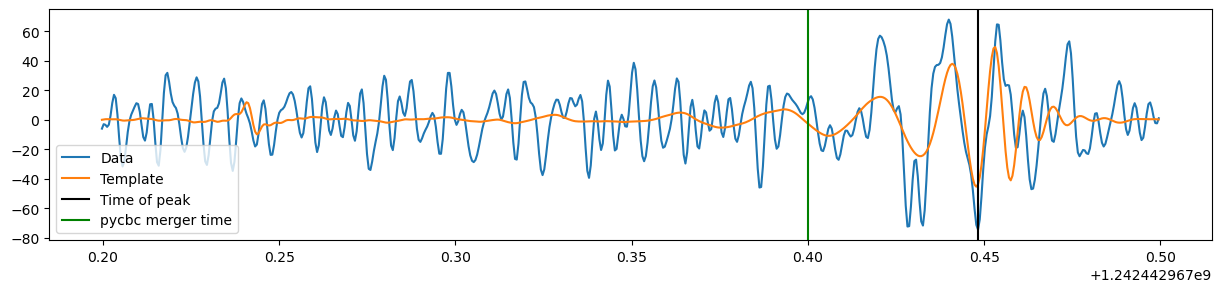

In [12]:
# We do it this way so that we can whiten both the template and the data
white_data = (conditioned.to_frequencyseries() / psd**0.5).to_timeseries()
white_template = (aligned.to_frequencyseries() / psd**0.5).to_timeseries()

white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

# Select the time around the merger
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

pylab.figure(figsize=[15, 3])
pylab.plot(white_data.sample_times, white_data, label="Data")
pylab.plot(white_template.sample_times, white_template, label="Template")
pylab.axvline(1242442967.4482422, color='k',label='Time of peak')
pylab.axvline(merger.time,color='g',label='pycbc merger time')
pylab.legend()
pylab.show()


In [9]:
import numpy as np
dir(white_data)

['__abs__',
 '__add__',
 '__array__',
 '__array_ufunc__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__idiv__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__isub__',
 '__itruediv__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__pow__',
 '__radd__',
 '__rdiv__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__rsub__',
 '__rtruediv__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__truediv__',
 '__weakref__',
 '_checkother',
 '_copy',
 '_data',
 '_delta_t',
 '_epoch',
 '_getslice',
 '_getvalue',
 '_icheckother',
 '_memoize_single',
 '_return',
 '_returnarray',
 '_returntype',
 '_saved',
 '_scheme',
 '_swighelper',
 '_typecheck',
 '_vcheckother',
 '_vrcheckother',
 'abs_arg_max',
 'abs_max_loc',
 'add_into',
 'almost_e

In [10]:
print(white_data.abs_arg_max())

509


In [11]:
print(white_data.sample_times[431])

1242442967.4101562
